
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

In [2]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rf666mb4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rf666mb4
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6c27d5a49c2f879b1280cf97012f4677a71a0c4c97375f841ab3be0ce8f00a0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-fq37cgy7/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy import stats
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import clip
from PIL import Image
from torchvision.datasets import CIFAR10
from torchvision import transforms
# from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

In [ ]:
# drive.mount('/content/drive')

# Task 1: Sparsity and Robustness

Please add your solution to this task from the manual in the cells below.

In [4]:
import numpy as np 
from scipy import stats

x = np.array([1, 1, 1, 6, 1, 1])

def L2(z):
    return np.sum((x - z)**2)

z_l2 = np.mean(x)
print("L2 Minimizer (z_hat_l2):", z_l2)

n = len(x)  
sum_x = np.sum(x)  
mean_x = sum_x / n  

print("Step-by-step breakdown:")
print("Sum of elements in x:", sum_x)
print("Number of elements in x (n):", n)
print("Mean of elements (z_hat_l2):", mean_x)

L2 Minimizer (z_hat_l2): 1.8333333333333333
Step-by-step breakdown:
Sum of elements in x: 11
Number of elements in x (n): 6
Mean of elements (z_hat_l2): 1.8333333333333333


In [5]:
z_l1 = np.median(x)
z_l1

1.0

In [6]:
z_l0 = stats.mode(x)[0][0]
z_l0

/var/folders/wt/07csprcj0b79dwm10ts4hh1m0000gn/T/ipykernel_59586/3948305444.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  z_l0 = stats.mode(x)[0][0]


1

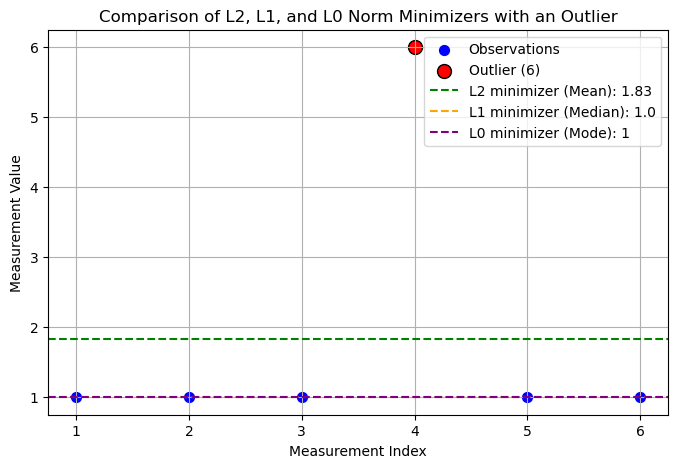

In [8]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))

# Plot the original data points
plt.scatter(range(1, len(x) + 1), x, color='blue', label='Observations', s=50)

# Highlight the outlier
plt.scatter(4, 6, color='red', label='Outlier (6)', s=100, edgecolor='black')

# Plot the estimators as horizontal lines
plt.axhline(y=z_l2, color='green', linestyle='--', label=f'L2 minimizer (Mean): {z_l2:.2f}')
plt.axhline(y=z_l1, color='orange', linestyle='--', label=f'L1 minimizer (Median): {z_l1}')
plt.axhline(y=z_l0, color='purple', linestyle='--', label=f'L0 minimizer (Mode): {z_l0}')

# Add labels and title
plt.xlabel('Measurement Index')
plt.ylabel('Measurement Value')
plt.title('Comparison of L2, L1, and L0 Norm Minimizers with an Outlier')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Task 2: Sparsity in Contrastive Models

Please add your solution to this task from the manual in the cells below.

In [20]:
import torch
import clip
from tqdm import tqdm  
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from google.colab import files
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter, OrderedDict
import string
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter, OrderedDict
import string

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

Using device: cuda


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [21]:
transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.48145466, 0.4578275, 0.40821073),(0.26862954, 0.26130258, 0.27577711))])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

cifar10_classes = train_dataset.classes
print("CIFAR-10 Classes:", cifar10_classes)

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [22]:

def generate_image_embeddings(model, dataloader, device):

    embeddings = []

    with torch.no_grad():

        for images, _ in dataloader:
            images = images.to(device)
            z_img = model.encode_image(images)
            z_img /= z_img.norm(dim=-1, keepdim=True)  
            embeddings.append(z_img.cpu())

    embeddings = torch.cat(embeddings, dim=0)

    return embeddings

print("Generating image embeddings for training set...")
train_image_embeddings = generate_image_embeddings(model, train_loader, device)
print("Generating image embeddings for test set...")
test_image_embeddings = generate_image_embeddings(model, test_loader, device)

def generate_text_embeddings(model, class_names, device):

    text_prompts = [f"a photo of a {classname}" for classname in class_names]

    text_tokens = clip.tokenize(text_prompts).to(device)

    with torch.no_grad():
        z_txt = model.encode_text(text_tokens)
        z_txt /= z_txt.norm(dim=-1, keepdim=True)  
    
    return z_txt.cpu()

print("Generating text embeddings for class labels...")

text_embeddings = generate_text_embeddings(model, cifar10_classes, device)

Generating image embeddings for training set...
Generating image embeddings for test set...
Generating text embeddings for class labels...


In [23]:
def zero_shot_classification(image_embeddings, text_embeddings):

    similarity = image_embeddings @ text_embeddings.T  # Shape: [num_images, num_classes]
    predicted_indices = similarity.argmax(dim=1).numpy()
    
    return predicted_indices

print("Performing zero-shot classification on the test set...")
predicted_classes = zero_shot_classification(test_image_embeddings, text_embeddings)

true_labels = test_dataset.targets

accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Zero-Shot Classification Accuracy on CIFAR-10 Test Set: {accuracy * 100:.2f}%")

Performing zero-shot classification on the test set...
Zero-Shot Classification Accuracy on CIFAR-10 Test Set: 87.78%


Visualizing some classification results...


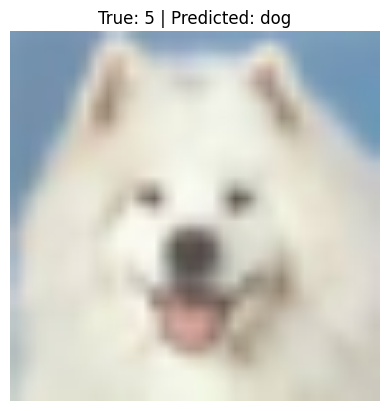

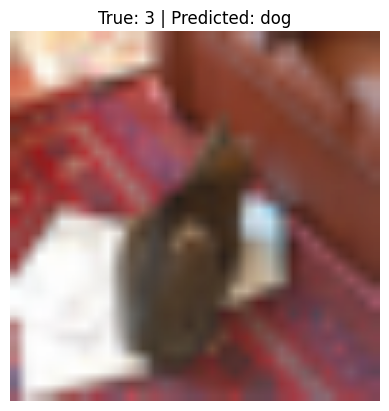

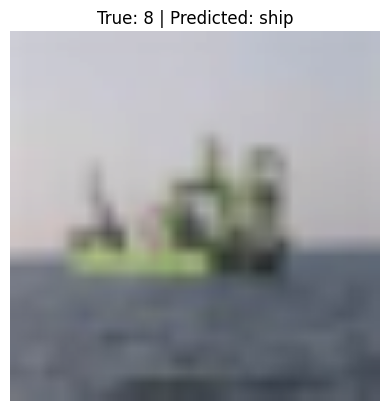

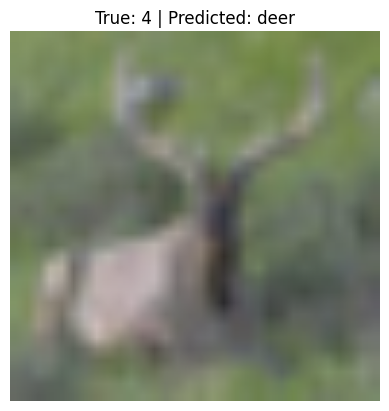

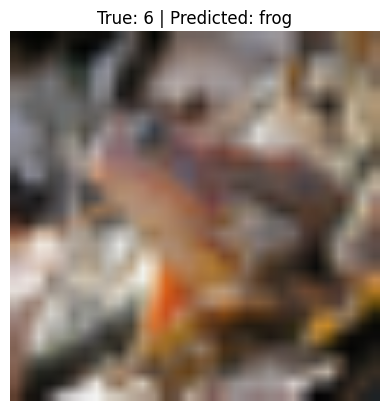

In [24]:

def show_predictions(dataset, image_embeddings, text_embeddings, num_samples=5):

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx in indices:

        image, true_label = dataset[idx]
        z_img = image_embeddings[idx].unsqueeze(0)
        similarity = z_img @ text_embeddings.T
        predicted_index = similarity.argmax().item()
        predicted_label = cifar10_classes[predicted_index]

        img = image.permute(1, 2, 0).numpy()
        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

print("Visualizing some classification results...")
show_predictions(test_dataset, test_image_embeddings, text_embeddings, num_samples=5)


In [39]:
uploaded = files.upload() 

with open('captions.txt', 'r', encoding='utf-8') as file:
    captions = file.read()

tokens = word_tokenize(captions.lower())
tokens = [word for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word not in stop_words]
pos_tags = nltk.pos_tag(filtered_tokens)
noun_tags = {'NN', 'NNS', 'NNP', 'NNPS'}
concepts = [word for word, tag in pos_tags if tag in noun_tags]

concept_counts = Counter(concepts)

top_1000_concepts = [word for word, freq in concept_counts.most_common(1000)]

print(f"Number of Unique Concepts Extracted: {len(top_1000_concepts)}")

cifar10_classes = train_dataset.classes  # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("CIFAR-10 Classes:", cifar10_classes)

top_1000_concepts += cifar10_classes

top_1000_concepts = list(OrderedDict.fromkeys(top_1000_concepts))

print(f"Total Concepts after Including CIFAR-10 Classes: {len(top_1000_concepts)}")

def generate_concept_dictionary(model, concept_words, device):

    text_prompts = [f"a photo of a {word}" for word in concept_words]

    text_tokens = clip.tokenize(text_prompts).to(device)

    with torch.no_grad():

        z_txt = model.encode_text(text_tokens)
        z_txt /= z_txt.norm(dim=-1, keepdim=True)

    A = z_txt.cpu().T  # Shape: [512, c]

    return A

print("Generating expanded concept dictionary A...")
A = generate_concept_dictionary(model, top_1000_concepts, device)
print(f"Expanded Concept Dictionary A Shape: {A.shape}")  

mu_img = test_image_embeddings.mean(dim=0, keepdim=True)  
print(f"Mean of Image Embeddings Shape: {mu_img.shape}")

mu_c = A.mean(dim=1, keepdim=True)  
print(f"Mean of Concept Dictionary A Shape: {mu_c.shape}")

z_c = test_image_embeddings - mu_img  # Shape: [10000, 512]
print(f"Centered Image Embeddings Shape: {z_c.shape}")

A_c = A - mu_c  # Shape: [512, c]
print(f"Centered Concept Dictionary A_c Shape: {A_c.shape}")

def normalize_embeddings(embeddings, dim=-1):
    return embeddings / embeddings.norm(dim=dim, keepdim=True)

z_c_normalized = normalize_embeddings(z_c, dim=1)  # Shape: [10000, 512]
print(f"Normalized Centered Image Embeddings Shape: {z_c_normalized.shape}")

A_c_normalized = normalize_embeddings(A_c, dim=0)  # Shape: [512, c]
print(f"Normalized Centered Concept Dictionary A_c Shape: {A_c_normalized.shape}")

A_c_normalized = A_c_normalized.to(device).float()  # Convert to float32
z_c_normalized = z_c_normalized.to(device).float()  # Convert to float32

print(f"A_c_normalized dtype: {A_c_normalized.dtype}")
print(f"z_c_normalized dtype: {z_c_normalized.dtype}")

Saving captions.txt to captions.txt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of Unique Concepts Extracted: 1000
CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Total Concepts after Including CIFAR-10 Classes: 1003
Generating expanded concept dictionary A...
Expanded Concept Dictionary A Shape: torch.Size([512, 1003])
Mean of Image Embeddings Shape: torch.Size([1, 512])
Mean of Concept Dictionary A Shape: torch.Size([512, 1])
Centered Image Embeddings Shape: torch.Size([10000, 512])
Centered Concept Dictionary A_c Shape: torch.Size([512, 1003])
Normalized Centered Image Embeddings Shape: torch.Size([10000, 512])
Normalized Centered Concept Dictionary A_c Shape: torch.Size([512, 1003])
A_c_normalized dtype: torch.float32
z_c_normalized dtype: torch.float32


In [51]:
def ista(A, b, lambda_reg, num_iters=100, learning_rate=1.0):
    """
    Solves the optimization problem:
        min_w ||b - A w||_2^2 + lambda_reg * ||w||_1
    using the Iterative Shrinkage-Thresholding Algorithm (ISTA).

    Parameters:
        A (torch.Tensor): The dictionary matrix of shape (d, c).
        b (torch.Tensor): The target embedding vector of shape (d,).
        lambda_reg (float): Regularization parameter for sparsity.
        num_iters (int): Number of ISTA iterations.
        learning_rate (float): Step size for gradient descent.

    Returns:
        w (torch.Tensor): The sparse weight vector of shape (c,).
    """

    w = torch.zeros(A.shape[1], device=A.device, dtype=A.dtype)

    for i in range(num_iters):

        gradient = 2 * A.t() @ (A @ w - b)
        w = w - learning_rate * gradient
        w = torch.sign(w) * F.relu(torch.abs(w) - learning_rate * lambda_reg)

    return w

lambda_reg = 0.05    
num_iters = 200      
learning_rate = 0.01 

A_c_normalized = A_c_normalized.to(device).float()  
z_c_normalized = z_c_normalized.to(device).float()  

print(f"A_c_normalized dtype: {A_c_normalized.dtype}")
print(f"z_c_normalized dtype: {z_c_normalized.dtype}")

A_c_t = A_c_normalized.T  # Shape: [c, d]

sparse_weights = []

print("Solving for sparse weight vectors using ISTA...")

for idx in range(z_c_normalized.shape[0]):

    b = z_c_normalized[idx]  # Shape: [d]
    w = ista(A_c_normalized, b, lambda_reg, num_iters, learning_rate)  # Shape: [c]
    sparse_weights.append(w.cpu())

sparse_weights = torch.stack(sparse_weights)  # Shape: [num_images, c]
print(f"Sparse Weights Shape: {sparse_weights.shape}")

print("Reconstructing sparse image embeddings...")
sparse_weights_device = sparse_weights.to(device)  # Shape: [num_images, c]
# Reconstruct z_hat_img = A * w + mu_c
# A has shape [d, c], and w has shape [num_images, c]
# To perform batch multiplication: z_hat_img = w @ A.T
z_hat_img = torch.matmul(sparse_weights_device, A_c_normalized.T) + mu_img.to(device).float()  # Shape: [num_images, d]
z_hat_img = z_hat_img.cpu()
print(f"Reconstructed Sparse Image Embeddings Shape: {z_hat_img.shape}")

A_c_normalized dtype: torch.float32
z_c_normalized dtype: torch.float32
Solving for sparse weight vectors using ISTA...
Sparse Weights Shape: torch.Size([10000, 1003])
Reconstructing sparse image embeddings...
Reconstructed Sparse Image Embeddings Shape: torch.Size([10000, 512])


In [52]:
print(f"text_embeddings dtype: {text_embeddings.dtype}")
print(f"test_image_embeddings dtype: {test_image_embeddings.dtype}")
print(f"z_hat_img_normalized dtype: {z_hat_img_normalized.dtype}")

def normalize_embeddings_batch(embeddings):
    return embeddings / embeddings.norm(dim=1, keepdim=True)

z_hat_img_normalized = normalize_embeddings_batch(z_hat_img)  # Shape: [10000, 512]
print(f"Normalized Reconstructed Sparse Image Embeddings Shape: {z_hat_img_normalized.shape}")

print("Computing cosine similarity for dense embeddings...")

text_embeddings = text_embeddings.to(torch.float32)

test_image_embeddings = test_image_embeddings.to(torch.float32)
print(f"test_image_embeddings dtype after conversion: {test_image_embeddings.dtype}")

similarity_dense = test_image_embeddings @ text_embeddings.T  # Shape: [10000, 1003]

print("Computing cosine similarity for sparse embeddings...")
similarity_sparse = z_hat_img_normalized @ text_embeddings.T  # Shape: [10000, 1003]

predicted_dense = similarity_dense.argmax(dim=1).cpu().numpy()  # Shape: [10000]
predicted_sparse = similarity_sparse.argmax(dim=1).cpu().numpy()  # Shape: [10000]

print("Evaluating classification performance...")
true_labels = test_dataset.targets  # Shape: [10000]

accuracy_dense = accuracy_score(true_labels, predicted_dense)
print(f"Zero-Shot Classification Accuracy with Dense Embeddings: {accuracy_dense * 100:.2f}%")

accuracy_sparse = accuracy_score(true_labels, predicted_sparse)
print(f"Zero-Shot Classification Accuracy with Sparse Embeddings: {accuracy_sparse * 100:.2f}%")


text_embeddings dtype: torch.float32
test_image_embeddings dtype: torch.float32
z_hat_img_normalized dtype: torch.float32
Normalized Reconstructed Sparse Image Embeddings Shape: torch.Size([10000, 512])
Computing cosine similarity for dense embeddings...
test_image_embeddings dtype after conversion: torch.float32
Computing cosine similarity for sparse embeddings...
Evaluating classification performance...
Zero-Shot Classification Accuracy with Dense Embeddings: 87.83%
Zero-Shot Classification Accuracy with Sparse Embeddings: 88.53%



Processing lambda_reg = 0.01


Processing Images: 100%|██████████| 10000/10000 [05:10<00:00, 32.16it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 696.90
Zero-Shot Classification Accuracy with Sparse Embeddings: 88.65%

Processing lambda_reg = 0.02


Processing Images: 100%|██████████| 10000/10000 [05:11<00:00, 32.14it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 476.53
Zero-Shot Classification Accuracy with Sparse Embeddings: 88.60%

Processing lambda_reg = 0.05


Processing Images: 100%|██████████| 10000/10000 [05:09<00:00, 32.30it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 215.27
Zero-Shot Classification Accuracy with Sparse Embeddings: 88.53%

Processing lambda_reg = 0.1


Processing Images: 100%|██████████| 10000/10000 [05:09<00:00, 32.28it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 84.69
Zero-Shot Classification Accuracy with Sparse Embeddings: 87.80%

Processing lambda_reg = 0.2


Processing Images: 100%|██████████| 10000/10000 [05:09<00:00, 32.30it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 18.54
Zero-Shot Classification Accuracy with Sparse Embeddings: 85.23%

Processing lambda_reg = 0.5


Processing Images: 100%|██████████| 10000/10000 [05:09<00:00, 32.26it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 1.04
Zero-Shot Classification Accuracy with Sparse Embeddings: 48.88%

Processing lambda_reg = 1


Processing Images: 100%|██████████| 10000/10000 [05:12<00:00, 32.02it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 0.00
Zero-Shot Classification Accuracy with Sparse Embeddings: 10.00%

Processing lambda_reg = 5


Processing Images: 100%|██████████| 10000/10000 [05:12<00:00, 32.01it/s]


Sparse Weights Shape: torch.Size([10000, 1003])
Average Non-Zero Weights per Image: 0.00
Zero-Shot Classification Accuracy with Sparse Embeddings: 10.00%


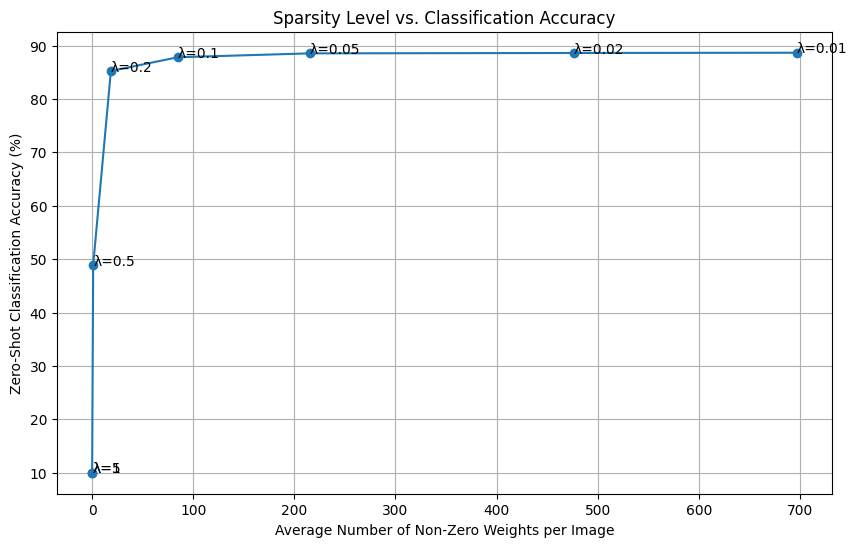

In [47]:
lambda_regs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 5]  
num_iters = 200
learning_rate = 0.01

sparsity_levels = []
accuracies_sparse = []

for lambda_reg in lambda_regs:

    print(f"\nProcessing lambda_reg = {lambda_reg}")

    sparse_weights = []
    for idx in tqdm(range(z_c_normalized.shape[0]), desc="Processing Images"):
        b = z_c_normalized[idx]  # Shape: [512]
        w = ista(A_c_normalized, b, lambda_reg, num_iters, learning_rate)  # Shape: [c]
        sparse_weights.append(w.cpu())

    sparse_weights = torch.stack(sparse_weights)  # Shape: [10000, c]
    print(f"Sparse Weights Shape: {sparse_weights.shape}")

    non_zero_counts = torch.count_nonzero(sparse_weights, dim=1)
    average_non_zero = non_zero_counts.float().mean().item()
    sparsity_levels.append(average_non_zero)
    print(f"Average Non-Zero Weights per Image: {average_non_zero:.2f}")

    sparse_weights_device = sparse_weights.to(device)  # Shape: [10000, c]
    z_hat_img = torch.matmul(sparse_weights_device, A_c_normalized.T) + mu_img.to(device).float()  # Shape: [10000, 512]
    z_hat_img = z_hat_img.cpu()

    z_hat_img_normalized = z_hat_img / z_hat_img.norm(dim=1, keepdim=True)  # Shape: [10000, 512]

    similarity_sparse = z_hat_img_normalized @ text_embeddings.T  # Shape: [10000, c]

    predicted_sparse = similarity_sparse.argmax(dim=1).numpy()  # Shape: [10000]

    accuracy_sparse = accuracy_score(true_labels, predicted_sparse)
    accuracies_sparse.append(accuracy_sparse * 100)

    print(f"Zero-Shot Classification Accuracy with Sparse Embeddings: {accuracy_sparse * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, accuracies_sparse, marker='o', linestyle='-')
for i, lambda_reg in enumerate(lambda_regs):
    plt.annotate(f"λ={lambda_reg}", (sparsity_levels[i], accuracies_sparse[i]))
plt.title("Sparsity Level vs. Classification Accuracy")
plt.xlabel("Average Number of Non-Zero Weights per Image")
plt.ylabel("Zero-Shot Classification Accuracy (%)")
plt.grid(True)
plt.show()

In [53]:
import numpy as np

def calculate_memory(elements, dtype_size=4):
    return (elements * dtype_size) / (1024 ** 2)

dense_shape = test_image_embeddings.shape  # [10000, 512]
dense_elements = dense_shape[0] * dense_shape[1]
dense_memory = calculate_memory(dense_elements)
print(f"Dense Embeddings Memory Footprint: {dense_memory:.2f} MB")

sparse_shape = sparse_weights.shape  # [10000, 1003]
sparse_elements = torch.count_nonzero(sparse_weights).item()
sparse_memory = calculate_memory(sparse_elements)
print(f"Sparse Embeddings Memory Footprint: {sparse_memory:.2f} MB")

Dense Embeddings Memory Footprint: 19.53 MB
Sparse Embeddings Memory Footprint: 8.21 MB


In [54]:
concept_non_zero_counts = torch.count_nonzero(sparse_weights, dim=0)  # Shape: [c]
concept_non_zero_counts = concept_non_zero_counts.numpy()

top_k = 20
top_concept_indices = concept_non_zero_counts.argsort()[-top_k:][::-1]
top_concepts = [top_1000_concepts[i] for i in top_concept_indices]

print("Top 20 Most Active Concepts:")
for rank, (idx, concept) in enumerate(zip(top_concept_indices, top_concepts), 1):
    print(f"{rank}. {concept} (Non-Zero Count: {concept_non_zero_counts[idx]})")


Top 20 Most Active Concepts:
1. cat (Non-Zero Count: 6182)
2. animals (Non-Zero Count: 5802)
3. deer (Non-Zero Count: 5767)
4. horses (Non-Zero Count: 5409)
5. horse (Non-Zero Count: 5135)
6. ship (Non-Zero Count: 5081)
7. frog (Non-Zero Count: 4891)
8. dog (Non-Zero Count: 4883)
9. vehicles (Non-Zero Count: 4811)
10. vehicle (Non-Zero Count: 4606)
11. works (Non-Zero Count: 4530)
12. farm (Non-Zero Count: 4448)
13. driver (Non-Zero Count: 4381)
14. video (Non-Zero Count: 4371)
15. pigeons (Non-Zero Count: 4332)
16. bat (Non-Zero Count: 4331)
17. crew (Non-Zero Count: 4302)
18. puppies (Non-Zero Count: 4290)
19. jet (Non-Zero Count: 4289)
20. job (Non-Zero Count: 4282)


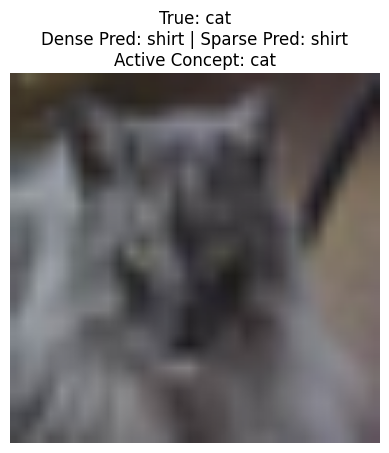

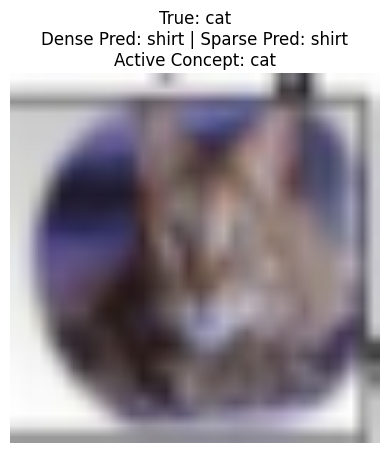

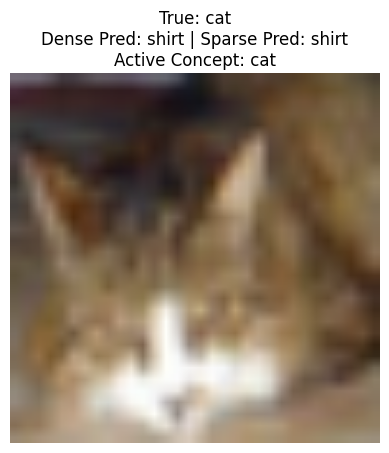

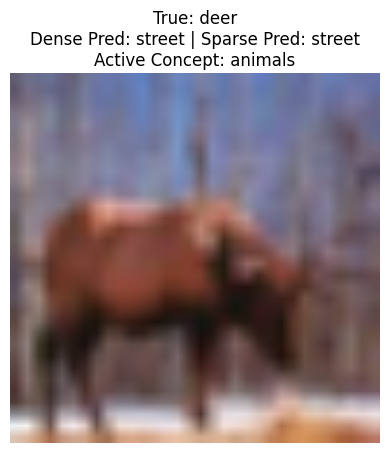

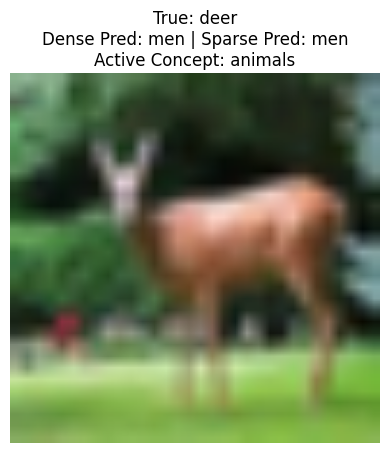

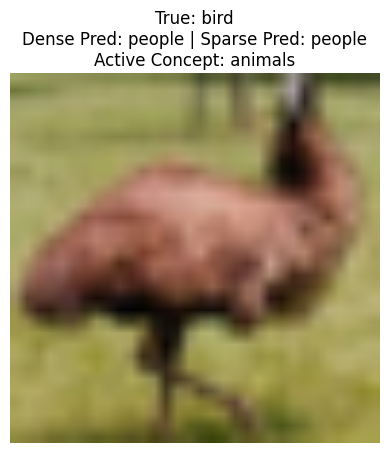

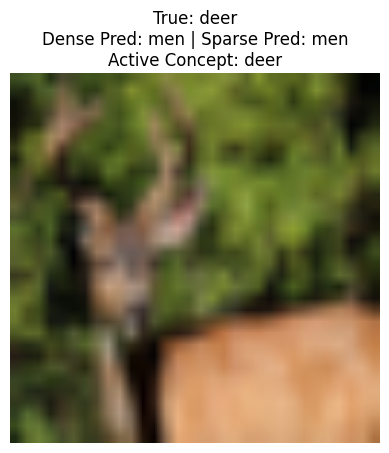

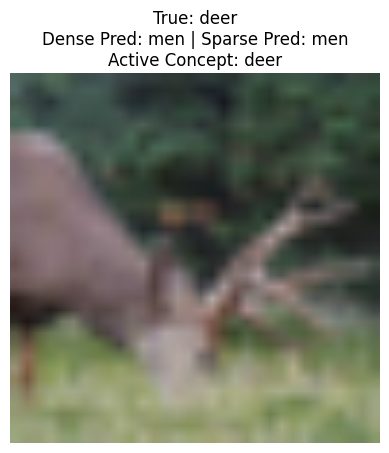

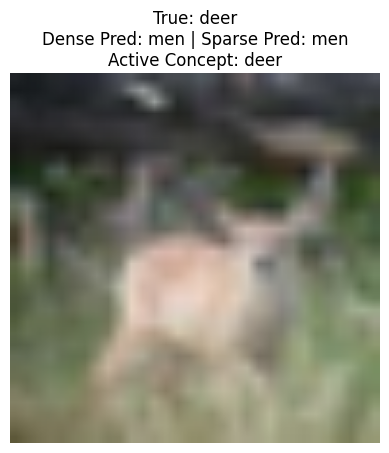

In [57]:
top_3_concepts = top_concepts[:3]

for concept in top_3_concepts:
    
    concept_idx = top_concept_indices[top_concepts.index(concept)]
    top_weight_threshold = torch.topk(sparse_weights[:, concept_idx], k=100, largest=True).values.min().item()
    relevant_indices = torch.where(sparse_weights[:, concept_idx] >= top_weight_threshold)[0].numpy()
    sample_indices = np.random.choice(relevant_indices, size=3, replace=False)

    for idx in sample_indices:

        image, true_label = test_dataset[idx]
        dense_pred = top_1000_concepts[predicted_dense[idx]] if predicted_dense[idx] < len(top_1000_concepts) else "Unknown"
        sparse_pred = top_1000_concepts[predicted_sparse[idx]] if predicted_sparse[idx] < len(top_1000_concepts) else "Unknown"

        img = image.permute(1, 2, 0).numpy()
        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f"True: {cifar10_classes[true_label]}\nDense Pred: {dense_pred} | Sparse Pred: {sparse_pred}\nActive Concept: {concept}")
        plt.axis('off')
        plt.show()